In [68]:
from pymatgen.core import Structure
import json

# Load from JSON
with open("sqs_structures.json", "r") as f:
    sqs_structures = json.load(f)

# Convert structure_dict back into Structure objects
sqs_structures = {frac: Structure.from_dict(struct_dict)
                      for frac, struct_dict in sqs_structures.items()}

In [69]:
# Manually select the desired fractions (as strings)
selected_keys = [
    '0.0', '0.1', '0.2', '0.30000000000000004', '0.4',
    '0.5', '0.6000000000000001', '0.7000000000000001', '0.8', '0.9'
]

# Filter to only those present in sqs_structures
selected_keys = [k for k in selected_keys if k in sqs_structures]

selected_structures = {k: sqs_structures[k] for k in selected_keys}

In [74]:
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.filters import FrechetCellFilter
from tqdm import tqdm

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

ev_to_gpa = 160.2176621
# Dictionary to store the results
mlp_elastic_moduli = {}

for name, pmg_struct in tqdm(selected_structures.items()):
    # Convert to ASE Atoms
    atoms = AseAtomsAdaptor.get_atoms(pmg_struct)
    
    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa/bulk_gpa
    
    # Store in dictionary
    mlp_elastic_moduli[name] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio
    }
    print(f"{name}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}")

 10%|█         | 1/10 [04:39<41:52, 279.21s/it]

0.0: Shear = 47.23 GPa, Bulk = 187.37 GPa, Pugh Ratio = 0.25


 20%|██        | 2/10 [09:46<39:25, 295.63s/it]

0.1: Shear = 52.46 GPa, Bulk = 198.48 GPa, Pugh Ratio = 0.26


 30%|███       | 3/10 [13:56<32:04, 274.87s/it]

0.2: Shear = 56.73 GPa, Bulk = 207.91 GPa, Pugh Ratio = 0.27


 40%|████      | 4/10 [18:43<27:59, 279.84s/it]

0.30000000000000004: Shear = 63.63 GPa, Bulk = 216.95 GPa, Pugh Ratio = 0.29


 50%|█████     | 5/10 [21:52<20:33, 246.74s/it]

0.4: Shear = 73.42 GPa, Bulk = 226.63 GPa, Pugh Ratio = 0.32


 60%|██████    | 6/10 [25:00<15:08, 227.08s/it]

0.5: Shear = 83.86 GPa, Bulk = 237.77 GPa, Pugh Ratio = 0.35


 70%|███████   | 7/10 [29:24<11:56, 238.94s/it]

0.6000000000000001: Shear = 99.51 GPa, Bulk = 253.42 GPa, Pugh Ratio = 0.39


 80%|████████  | 8/10 [34:24<08:36, 258.44s/it]

0.7000000000000001: Shear = 116.06 GPa, Bulk = 270.55 GPa, Pugh Ratio = 0.43


 90%|█████████ | 9/10 [38:03<04:05, 245.97s/it]

0.8: Shear = 132.28 GPa, Bulk = 284.86 GPa, Pugh Ratio = 0.46


100%|██████████| 10/10 [41:15<00:00, 247.50s/it]

0.9: Shear = 145.73 GPa, Bulk = 294.08 GPa, Pugh Ratio = 0.50


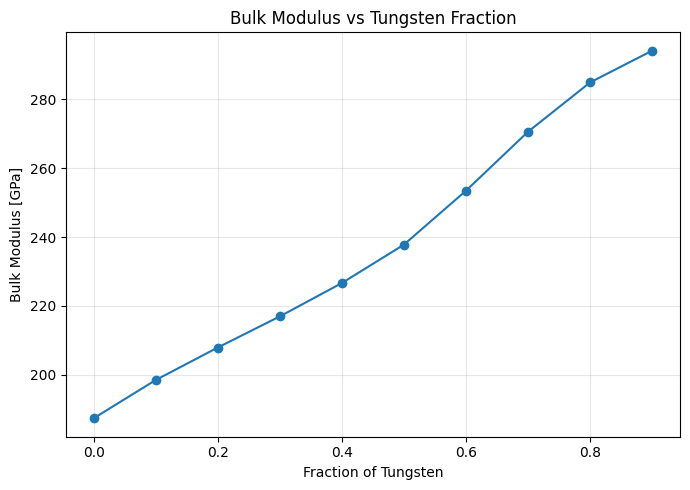

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
fractions = np.array([float(k) for k in mlp_elastic_moduli.keys()])
bulk_modulus = np.array([v['bulk_modulus_vrh'] for v in mlp_elastic_moduli.values()])
shear_modulus = np.array([v['shear_modulus_vrh'] for v in mlp_elastic_moduli.values()])
pugh_ratio = np.array([v['pugh_ratio'] for v in mlp_elastic_moduli.values()])

# Sort by fraction
sort_idx = np.argsort(fractions)
fractions = fractions[sort_idx]
sqs_bulk_modulus = bulk_modulus[sort_idx]
sqs_shear_modulus = shear_modulus[sort_idx]
sqs_pugh_ratio = pugh_ratio[sort_idx]

# Plot Bulk modulus
plt.figure(figsize=(7,5))
plt.plot(fractions, sqs_bulk_modulus, marker='o', label='Bulk modulus (VRH)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('Bulk Modulus [GPa]')
plt.title('Bulk Modulus vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

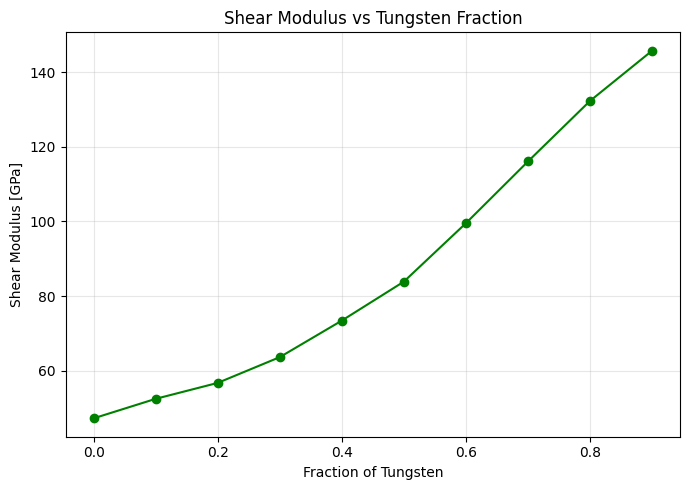

In [76]:
# Plot Shear modulus
plt.figure(figsize=(7,5))
plt.plot(fractions, sqs_shear_modulus, marker='o', color='green', label='Shear modulus (VRH)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('Shear Modulus [GPa]')
plt.title('Shear Modulus vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

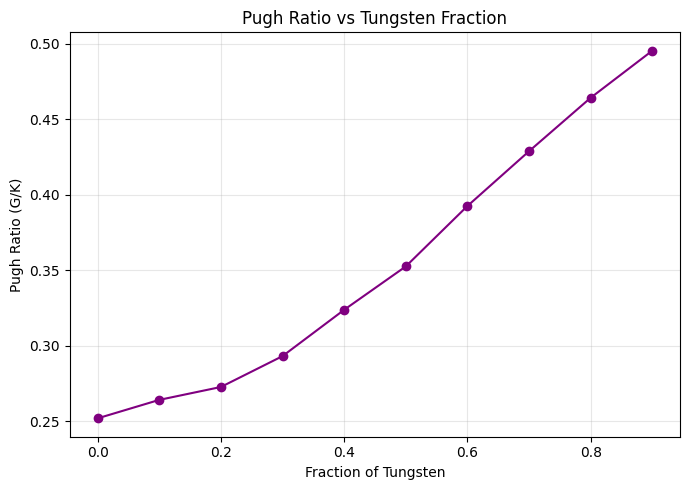

In [77]:
# Plot Pugh ratio
plt.figure(figsize=(7,5))
plt.plot(fractions, sqs_pugh_ratio, marker='o', color='purple', label='Pugh Ratio (G/K)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('Pugh Ratio (G/K)')
plt.title('Pugh Ratio vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Compare to the Ordered Structures

In [52]:
import json
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor

# Load from JSON
with open("relaxed_structures_with_energies.json", "r") as f:
    data = json.load(f)

# Reconstruct formation_energies as a list of (ase.Atoms, formation_energy)
formation_energies = []
for entry in data:
    pmg_struct = Structure.from_dict(entry["structure"])
    atoms = AseAtomsAdaptor.get_atoms(pmg_struct)
    formation_energies.append((atoms, entry["formation_energy"]))

In [53]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

lowest_by_comp = defaultdict(lambda: (None, np.inf))

for atoms, E_form in tqdm(formation_energies):
    formula = atoms.get_chemical_formula()
    if E_form < lowest_by_comp[formula][1]:
        lowest_by_comp[formula] = (atoms, E_form)

# print results
for formula, (atoms, E_form) in lowest_by_comp.items():
    print(f"{formula}: lowest formation energy = {E_form:.4f} eV/atom")

100%|██████████| 4764/4764 [00:00<00:00, 97064.34it/s]

NbW9: lowest formation energy = -0.0282 eV/atom
NbTaW8: lowest formation energy = -0.0623 eV/atom
NbTa2W7: lowest formation energy = -0.0827 eV/atom
NbTa3W6: lowest formation energy = -0.0895 eV/atom
NbTa4W5: lowest formation energy = -0.0882 eV/atom
NbTa5W4: lowest formation energy = -0.0799 eV/atom
NbTa6W3: lowest formation energy = -0.0638 eV/atom
NbTa7W2: lowest formation energy = -0.0442 eV/atom
NbTa8W: lowest formation energy = -0.0237 eV/atom
NbTa9: lowest formation energy = -0.0008 eV/atom


In [54]:
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.filters import FrechetCellFilter
from tqdm import tqdm

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

ev_to_gpa = 160.2176621
mlp_elastic_moduli = {}

for name, (atoms, E_form) in tqdm(lowest_by_comp.items()):
    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
        relax_initial=False,
        relax_strained=False,
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa / bulk_gpa
    
    # Store in dictionary
    mlp_elastic_moduli[name] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio,
        'formation_energy': E_form
    }
    print(f"{name}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}, Formation Energy = {E_form:.4f} eV/atom")

 10%|█         | 1/10 [00:08<01:20,  8.99s/it]

NbW9: Shear = 147.29 GPa, Bulk = 295.72 GPa, Pugh Ratio = 0.50, Formation Energy = -0.0282 eV/atom


 20%|██        | 2/10 [00:21<01:28, 11.01s/it]

NbTaW8: Shear = 135.63 GPa, Bulk = 287.30 GPa, Pugh Ratio = 0.47, Formation Energy = -0.0623 eV/atom


 30%|███       | 3/10 [00:33<01:20, 11.49s/it]

NbTa2W7: Shear = 119.11 GPa, Bulk = 272.65 GPa, Pugh Ratio = 0.44, Formation Energy = -0.0827 eV/atom


 40%|████      | 4/10 [00:47<01:14, 12.44s/it]

NbTa3W6: Shear = 103.18 GPa, Bulk = 255.36 GPa, Pugh Ratio = 0.40, Formation Energy = -0.0895 eV/atom


 50%|█████     | 5/10 [01:01<01:04, 12.94s/it]

NbTa4W5: Shear = 89.49 GPa, Bulk = 241.51 GPa, Pugh Ratio = 0.37, Formation Energy = -0.0882 eV/atom


 60%|██████    | 6/10 [01:13<00:51, 12.85s/it]

NbTa5W4: Shear = 79.39 GPa, Bulk = 230.40 GPa, Pugh Ratio = 0.34, Formation Energy = -0.0799 eV/atom


 70%|███████   | 7/10 [01:35<00:47, 15.85s/it]

NbTa6W3: Shear = 70.49 GPa, Bulk = 218.50 GPa, Pugh Ratio = 0.32, Formation Energy = -0.0638 eV/atom


 80%|████████  | 8/10 [01:52<00:32, 16.19s/it]

NbTa7W2: Shear = 62.32 GPa, Bulk = 209.03 GPa, Pugh Ratio = 0.30, Formation Energy = -0.0442 eV/atom


 90%|█████████ | 9/10 [02:07<00:15, 15.59s/it]

NbTa8W: Shear = 54.94 GPa, Bulk = 199.35 GPa, Pugh Ratio = 0.28, Formation Energy = -0.0237 eV/atom


100%|██████████| 10/10 [02:21<00:00, 14.10s/it]

NbTa9: Shear = 47.65 GPa, Bulk = 187.56 GPa, Pugh Ratio = 0.25, Formation Energy = -0.0008 eV/atom


In [55]:
import matplotlib.pyplot as plt
import numpy as np
import re

def tungsten_fraction(formula):
    # Extract number after 'W' (or 1 if just 'W')
    match = re.search(r'W(\d*)', formula)
    if match:
        w_count = int(match.group(1)) if match.group(1) else 1
    else:
        w_count = 0
    # Extract all element counts
    counts = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    total = sum(int(n) if n else 1 for el, n in counts)
    return w_count / total if total > 0 else 0

# Prepare data for plotting
fractions = np.array([tungsten_fraction(k) for k in mlp_elastic_moduli.keys()])
bulk_modulus = np.array([v['bulk_modulus_vrh'] for v in mlp_elastic_moduli.values()])
shear_modulus = np.array([v['shear_modulus_vrh'] for v in mlp_elastic_moduli.values()])
pugh_ratio = np.array([v['pugh_ratio'] for v in mlp_elastic_moduli.values()])

# Sort by fraction
sort_idx = np.argsort(fractions)
fractions = fractions[sort_idx]
bulk_modulus = bulk_modulus[sort_idx]
shear_modulus = shear_modulus[sort_idx]
pugh_ratio = pugh_ratio[sort_idx]

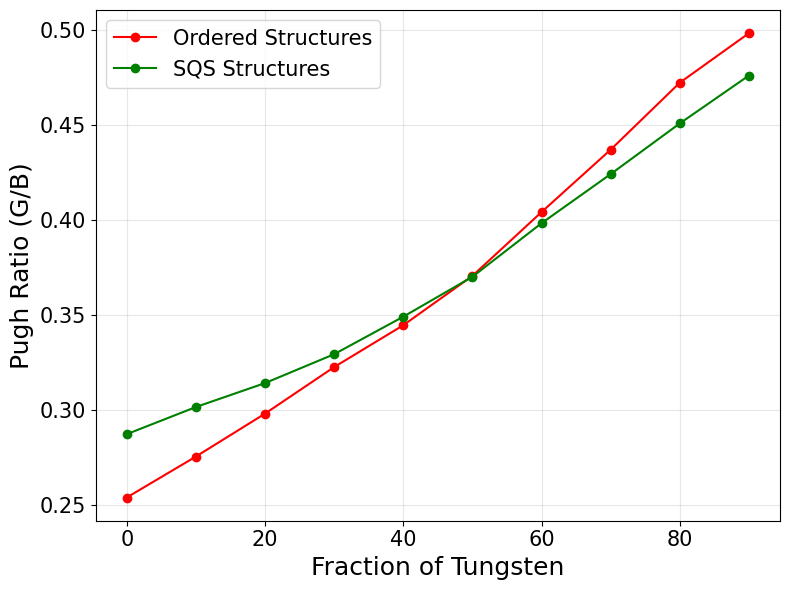

In [66]:
# Plot Pugh ratio vs Tungsten fraction with larger fonts
plt.figure(figsize=(8,6))
plt.plot(fractions*100, pugh_ratio, marker='o', color='red', label='Ordered Structures')
plt.plot(fractions*100, sqs_pugh_ratio, marker='o', color='green', label='SQS Structures')
plt.xlabel('Fraction of Tungsten', fontsize=18)
plt.ylabel('Pugh Ratio (G/B)', fontsize=18)
# plt.title('Pugh Ratio vs Tungsten Fraction', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend(fontsize=15)